<a href="https://colab.research.google.com/github/Solitte/C-_DZ/blob/main/DZ3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность.
2. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке

In [68]:
pip install -U keras-tuner

План по улучшению:
 - Составить несколько моделей с разными параметрами;
 - Поискать оптимальные варианты;
 - Применить несколько разных оптимайзеров;
 - Применить callback;
 - Сделать сборку предсказаний из нескольких моделей (Идея обучить одну из моделей на обратном векторе);

In [69]:
# from __future__ import absolute_import,division, print_function, unicode_literals

#TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical, to_ordinal
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
%matplotlib inline
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, accuracy_score

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from google.colab import files
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import numpy as np
%tensorflow_version 2.x

print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


## Импортируем Fashion MNIST датасет

In [70]:
from keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize.
train_images = (train_images / 255)
test_images = (test_images / 255)


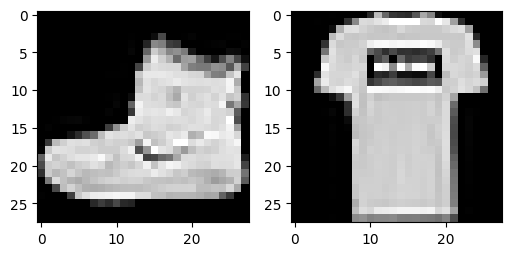

In [71]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(train_images[1], cmap='gray')

Датасет содержит следующие классы:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Каждому классу обозначенному цифрой мы можем присвоить текстовое значение -

In [72]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Для процесса обучения нейронной сети нам важно перевести данные из диапазона от 0 до 255 в диапазон от 0 до 1:

### Определение слоев

Давайте создадим 3 слоя нейронной сети с помощью функционала Keras.layers

In [73]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28), name='input'),
    keras.layers.Dense(256, activation='relu', name='hiden_one'),
    keras.layers.Dense(128, activation='relu', name='hiden_two'),
    keras.layers.Dense(64, activation='relu', name='hiden_three'),
    keras.layers.Dense(32, activation='relu', name='hiden_four'),
    keras.layers.Dense(10, name='output')
])
config = model.get_config()
model.save_weights('fashion_weights.h5')

313/313 - 1s - loss: 0.3493 - accuracy: 0.8916 - 705ms/epoch - 2ms/step

Test accuracy: 0.8916000127792358
313/313 [==============================] - 1s 2ms/step


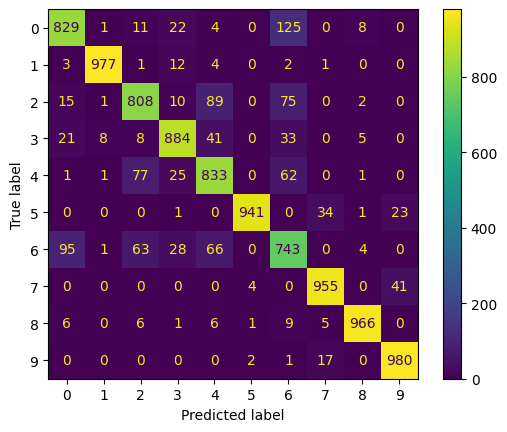

In [74]:
model = model.from_config(config)
model.load_weights('fashion_weights.h5')


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size = 250, epochs=25, verbose=0)
  # model.fit(train_images, train_labels, batch_size = 250, epochs=el, verbose=0, validation_data=(test_images, test_labels))
  # model.fit(train_images, train_labels, batch_size = 10, epochs=10, verbose=0, validation_data=(test_images, test_labels), callbacks=[reduce_lr])
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
  # Получим предсказания
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)
# Посмотрим на результаты
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

In [75]:
def recall_precision(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
  precision = precision_score(y_true, y_pred, labels=labels, average=None)
  recall = recall_score(y_true, y_pred, labels=labels, average=None)
  for i, el in enumerate(zip(precision, recall)):
    print(f'Класс - {i}, точность - {el[0]:.3f}, полнота - {el[1]:.3f}')

In [76]:
recall_precision(test_labels, y_pred)

Класс - 0, точность - 0.855, полнота - 0.829
Класс - 1, точность - 0.988, полнота - 0.977
Класс - 2, точность - 0.830, полнота - 0.808
Класс - 3, точность - 0.899, полнота - 0.884
Класс - 4, точность - 0.799, полнота - 0.833
Класс - 5, точность - 0.993, полнота - 0.941
Класс - 6, точность - 0.708, полнота - 0.743
Класс - 7, точность - 0.944, полнота - 0.955
Класс - 8, точность - 0.979, полнота - 0.966
Класс - 9, точность - 0.939, полнота - 0.980


После теста этих параметров нейросети, созданной на уроке, особого улучшить модель неполучилось

Нашелся Keras-tuner, для пербора парваметров, чтобы непариться вручную.

In [77]:
def build_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
    model.add(Dense(units=hp.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=512,    # минимальное количество нейронов - 128
                                   max_value=1024,   # максимальное количество - 1024
                                   step=32),
                    input_dim=784,
                    activation=activation_choice))
    for i in range(1, hp.Int("num_layers", 2, 6)):
            model.add(Dense(units=hp.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=512,    # минимальное количество нейронов - 128
                                   max_value=1024,   # максимальное количество - 1024
                                   step=32),
                    activation=activation_choice))
    model.add(Dense(10, activation='softmax'))
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam','rmsprop','SGD']),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

## Подготовка данных для обучения сети

In [78]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [79]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train / 255
x_test = x_test / 255
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

## Создаем tuner

Доступные типы тюнеров:
- RandomSearch - случайный поиск.
- Hyperband - алгоритм оптимизации на основе многорукого бандита, Li, Lisha, and Kevin Jamieson.
- BayesianOptimization - байесовская оптимизация

In [80]:
tuner = BayesianOptimization(
    build_model,                 # функция создания модели
    objective='val_accuracy',    # метрика, которую нужно оптимизировать -
                                 # доля правильных ответов на проверочном наборе данных
    max_trials=100,               # максимальное количество запусков обучения
    directory='test_directory'   # каталог, куда сохраняются обученные сети
    )

Reloading Tuner from test_directory/untitled_project/tuner0.json


## Подбор гиперпараметров

In [81]:
tuner.search(x_train,                  # Данные для обучения
             y_train,                  # Правильные ответы
             batch_size=256,           # Размер мини-выборки
             epochs=20,                # Количество эпох обучения
             validation_split=0.2,     # Часть данных, которая будет использоваться для проверки
             )

Trial 100 Complete [00h 00m 30s]
val_accuracy: 0.8843333125114441

Best val_accuracy So Far: 0.9000833630561829
Total elapsed time: 01h 02m 16s


## Выбираем лучшую модель

In [82]:
models = tuner.get_best_models(num_models=2)

Оцениваем качество модели на тестовых данных

In [83]:
for model in models:
  model.summary()
  model.evaluate(x_test, y_test)
  print()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 672)               527520    
                                                                 
 dense_1 (Dense)             (None, 672)               452256    
                                                                 
 dense_2 (Dense)             (None, 10)                6730      
                                                                 
Total params: 986506 (3.76 MB)
Trainable params: 986506 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.3527 - accuracy: 0.8915

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)  

Тесты показали, что модель - слой(640 неройнов) - слой(640 неройнов) -слой(10 неройнов) , показала лучшую точность на тестовых данных 0.8937

---

